In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from PyIF import te_compute as te
from sklearn import metrics

from osgeo import gdal, osr, ogr
from tqdm import tqdm
from scipy import stats, spatial, signal, fftpack
from scipy.optimize import curve_fit


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
gdf = gp.read_file("../shape/sierra_catchments.shp")

In [3]:

def get_fnf(stn_id):
    '''
    Query CA DWR website to get reservoir storage for an area of interest
    '''
    print("**** Fetching FNF for {} ****".format(stn_id))

    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=8&dur_code=D&Start=2003-09-01&End=2021-09-01".format(stn_id)
    df = pd.read_csv(url)

    df[stid] = pd.to_numeric(df['VALUE'], errors='coerce').interpolate(how = 'linear') * 0.0283168 # cfs --> cms 
    df.index = pd.to_datetime(df['DATE TIME'])
    df.index.names = ['date']
    df.drop(['STATION_ID', "VALUE", "DURATION", "SENSOR_NUMBER", 
             "SENSOR_TYPE", "OBS DATE",'DATE TIME', "DATA_FLAG", "UNITS"], axis = 1, inplace = True)

    df[df[stid] < 0] = np.nan
#     df[stid] = df[stid].rolling(7).mean()
    return df# .interpolate(how = 'polynomial', order = 3)

In [4]:
results_df = []

**** Fetching FNF for SHA ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.0014889024857228398,  b=1.6866356893909822, K = 671.6356575323433


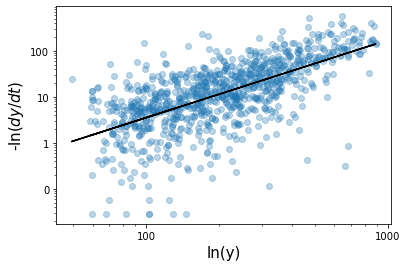

**** Fetching FNF for YRS ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.07815694911965551,  b=1.0353360916869967, K = 12.79476759602061


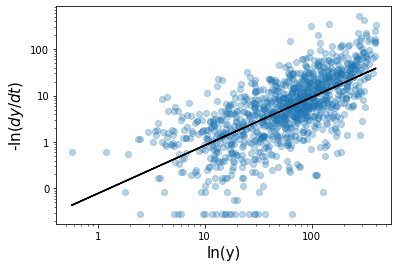

**** Fetching FNF for NHG ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.2643692085118847,  b=0.781524952184847, K = 3.782588772833751


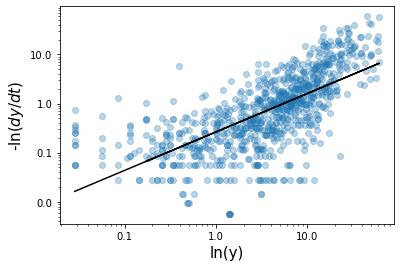

**** Fetching FNF for EXC ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.12089518021374254,  b=0.9574922809940571, K = 8.271628349715854


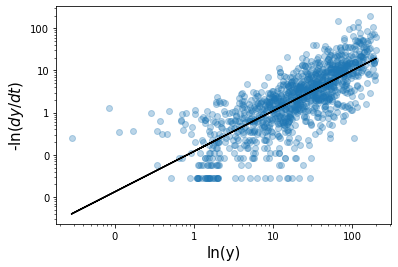

**** Fetching FNF for PNF ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.11322221351999925,  b=0.8995406789823941, K = 8.832189098858793


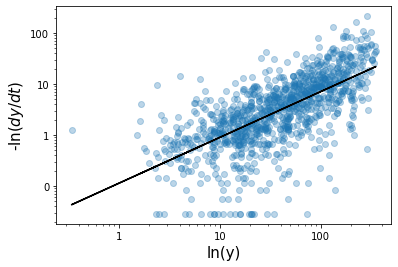

**** Fetching FNF for SCC ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.12077285714404902,  b=0.6792139568330822, K = 8.280006150779998


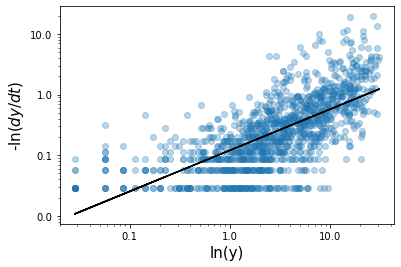

**** Fetching FNF for MKM ****
Parameters: a=0.41067234439983963,  b=0.6444435876491698, K = 2.4350312691774003


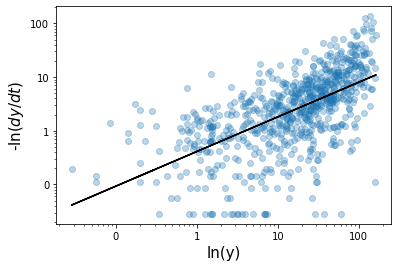

**** Fetching FNF for TRM ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.07653207027101755,  b=0.9773355509566733, K = 13.066417731269668


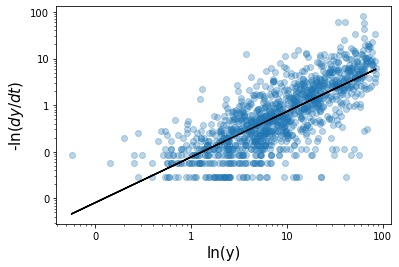

**** Fetching FNF for ORO ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.051618493933219226,  b=1.122214194853854, K = 19.372901528156504


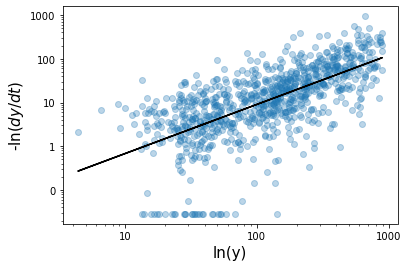

**** Fetching FNF for NML ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.1470461269816828,  b=0.8876958794735087, K = 6.800587139058534


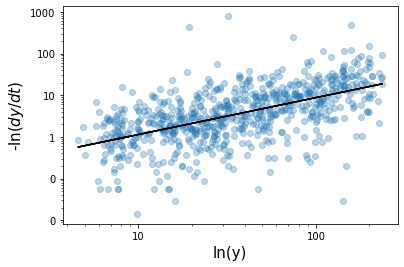

**** Fetching FNF for MHB ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.06044306301791792,  b=1.055361380976108, K = 16.544495762955577


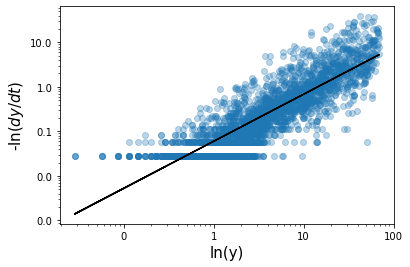

**** Fetching FNF for NAT ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.1944270473657776,  b=0.9031795495248296, K = 5.1433173190080375


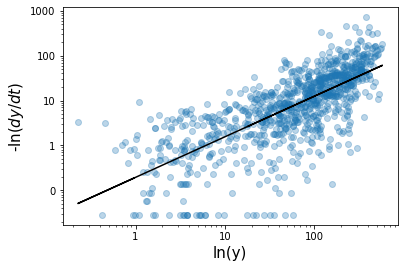

**** Fetching FNF for ISB ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.04949757646938422,  b=1.0486330884567425, K = 20.203009345690507


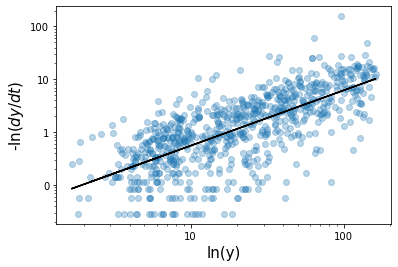

**** Fetching FNF for TLG ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.18957532397719254,  b=0.8846026342941539, K = 5.274948126267257


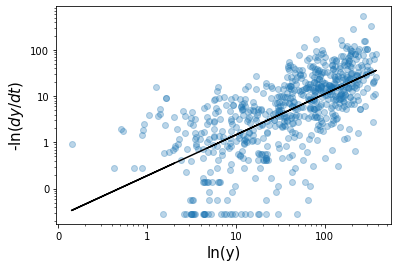

**** Fetching FNF for SJF ****


<ipython-input-5-31875982fd4e>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.16114652625339956,  b=0.8799864888055499, K = 6.205532463216246


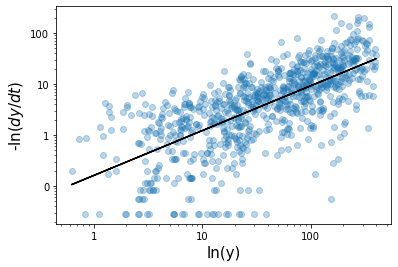

In [5]:
for stid in list(gdf['stid'])[::-1]:
        
    fnf_df = get_fnf(stid)

    hdf = fnf_df.copy()

    hdf.columns = ['y']
    hdf['y'] = hdf['y'] #
    hdf['dy'] = hdf['y'].diff()

    hdf = hdf.dropna()

    # Drop rows with increasing baseflow 
    droprows = []
    for idx, row in hdf.reset_index().iterrows():
        if row['dy'] > 0:
            droprows.append([idx + x for x in list(range(-1,2))])

    drs = [item for sublist in droprows for item in sublist]
    drs = [x for x in drs if x>=0 and x <len(hdf)]

    odf = hdf.reset_index().drop(hdf.reset_index().index[drs]).set_index(['date'])

    # Remove vvv small values 
    odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]

    # Remove outliers 
    odf = odf[(np.abs(stats.zscore(odf['y'])) < 3)]

    # keep only summer 
    odf['midx'] = odf.index.month
    odf[odf['midx'].isin([5,6,7,8,9,10])]

    odf.dropna(inplace = True)
    x = odf['y'].values
    y = odf['dy'].abs().values

    def f(x, a, b):
        return np.log(a*x**b)

    popt,pcov=curve_fit(f, x, np.log(y))

    ax = plt.gca()

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(x,y, alpha = 0.3)

    a, b = popt
    print("Parameters: a={},  b={}, K = {}".format(a,b, 1/a))

    #parameter form curve_fit
    py=a*x**b

    ax.loglog(x,py,  color="k")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
    # ax.set_xlim([0.01,10])
    # ax.set_ylim([0.0001,1])
    ax.set_ylabel("-ln($dy/dt$)", size = 15)
    ax.set_xlabel("ln(y)", size = 15)
    plt.show()

In [6]:
results_df = []
param_df = []

In [7]:
for stid in list(gdf['stid'])[:]:
        
    fnf_df = get_fnf(stid)

    hdf = fnf_df.copy()

    hdf.columns = ['y']
    hdf['y'] = hdf['y'] #
    hdf['dy'] = hdf['y'].diff()

    hdf = hdf.dropna()

    # Drop rows with increasing baseflow 
    droprows = []
    for idx, row in hdf.reset_index().iterrows():
        if row['dy'] > 0:
            droprows.append([idx + x for x in list(range(-1,2))])

    drs = [item for sublist in droprows for item in sublist]
    drs = [x for x in drs if x>=0 and x <len(hdf)]

    odf = hdf.reset_index().drop(hdf.reset_index().index[drs]).set_index(['date'])

    # Remove vvv small values 
    odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]

    # Remove outliers 
    odf = odf[(np.abs(stats.zscore(odf['y'])) < 3)]

    # keep only summer 
    odf['midx'] = odf.index.month
    odf[odf['midx'].isin([6,7,8])]

    odf.dropna(inplace = True)
    x = odf['y'].values
    y = odf['dy'].abs().values

    def f(x, a, b):
        return np.log(a*x**b)

    popt,pcov=curve_fit(f, x, np.log(y))

#     ax = plt.gca()

#     ax.set_xscale("log")
#     ax.set_yscale("log")

#     ax.scatter(x,y, alpha = 0.3)
    
    temp_df = pd.DataFrame([x,y]).T
    temp_df.columns = ['y','dy']
    temp_df['id'] = [stid for x in range(len(temp_df))]
    results_df.append(temp_df)
    
    pdf = pd.DataFrame([popt[0],popt[1],stid]).T
    pdf.columns = ['a','b','id']
    param_df.append(pdf)

    a, b = popt
    print("Parameters: a={},  b={}, K = {}".format(a,b, 1/a))

    #parameter form curve_fit
    py=a*x**b

#     ax.loglog(x,py,  color="k")
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     # ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
#     # ax.set_xlim([0.01,10])
#     # ax.set_ylim([0.0001,1])
#     ax.set_ylabel("-ln($dy/dt$)", size = 15)
#     ax.set_xlabel("ln(y)", size = 15)
#     plt.show()

**** Fetching FNF for SJF ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.16114652625339956,  b=0.8799864888055499, K = 6.205532463216246
**** Fetching FNF for TLG ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.18957532397719254,  b=0.8846026342941539, K = 5.274948126267257
**** Fetching FNF for ISB ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.04949757646938422,  b=1.0486330884567425, K = 20.203009345690507
**** Fetching FNF for NAT ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.1944270473657776,  b=0.9031795495248296, K = 5.1433173190080375
**** Fetching FNF for MHB ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.06044306301791792,  b=1.055361380976108, K = 16.544495762955577
**** Fetching FNF for NML ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.1470461269816828,  b=0.8876958794735087, K = 6.800587139058534
**** Fetching FNF for ORO ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.051618493933219226,  b=1.122214194853854, K = 19.372901528156504
**** Fetching FNF for TRM ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.07653207027101755,  b=0.9773355509566733, K = 13.066417731269668
**** Fetching FNF for MKM ****
Parameters: a=0.41067234439983963,  b=0.6444435876491698, K = 2.4350312691774003
**** Fetching FNF for SCC ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.12077285714404902,  b=0.6792139568330822, K = 8.280006150779998
**** Fetching FNF for PNF ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.11322221351999925,  b=0.8995406789823941, K = 8.832189098858793
**** Fetching FNF for EXC ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.12089518021374254,  b=0.9574922809940571, K = 8.271628349715854
**** Fetching FNF for NHG ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.2643692085118847,  b=0.781524952184847, K = 3.782588772833751
**** Fetching FNF for YRS ****


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


Parameters: a=0.07815694911965551,  b=1.0353360916869967, K = 12.79476759602061
**** Fetching FNF for SHA ****
Parameters: a=0.0014889024857228398,  b=1.6866356893909822, K = 671.6356575323433


<ipython-input-7-da376e0128f2>:39: RuntimeWarning: invalid value encountered in log
  return np.log(a*x**b)


In [8]:
# Master plot
plot_df = pd.concat(results_df, axis = 0)
popt_global,pcov_global=curve_fit(f, plot_df['y'], np.log(plot_df['dy']))
py_glob = popt_global[0]*plot_df['y']**popt_global[1]

/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


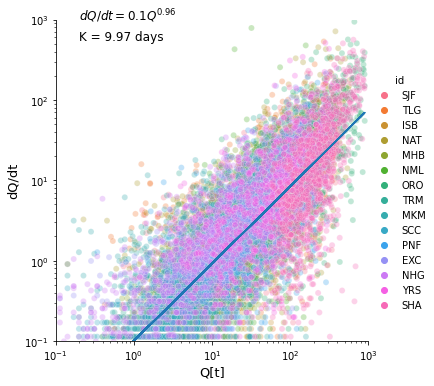

In [9]:
sns.relplot(data=plot_df, x='y', y='dy', hue='id', aspect=1, alpha = 0.3)
plt.plot(plot_df['y'],py_glob)
text = ("$dQ/dt = {{{}}} Q^{{{}}}$").format(round(popt_global[0],2), round(popt_global[1],2))
text2 = ("K = {} days").format(round(1/popt_global[0],2))

plt.annotate(text, xy = (0.2,1000), size = 12)
plt.annotate(text2, xy = (0.2,550), size = 12)
plt.ylim([1e-1,1e3])
plt.xlim([1e-1,1e3])
plt.yscale('log')
plt.xscale('log')
plt.ylabel("dQ/dt", size = 13)
plt.xlabel("Q[t]", size = 13)
plt.show()

In [11]:
popt_global,pcov_global=curve_fit(f, plot_df['y'], np.log(plot_df['dy']))

/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
ys = []

for idx, row in pd.concat(param_df, axis = 0).dropna().iterrows():
    ydf= pd.DataFrame(np.array([row['a']*x**row['b'] for x in np.linspace(0,10000,100)]))
    ydf.columns=[row['id']]
    ys.append(ydf)
    
    

In [13]:
sddf = pd.concat(ys, axis = 1).dropna()

(0.0001, 500.0)

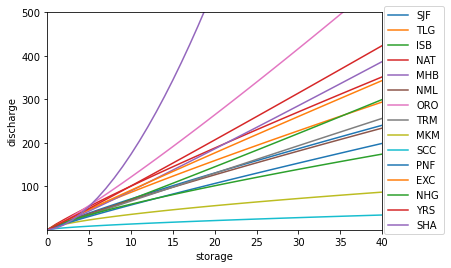

In [14]:
sddf.plot()
plt.legend(loc='upper right', bbox_to_anchor = (1.2,1.05))
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel("storage")
plt.ylabel("discharge")
plt.xlim([0,40])
plt.ylim([1e-4,500])

In [ ]:
stn_id = "ORO"

# wshed shapefile
gdf = gp.read_file("../shape/{}.shp".format(stn_id))
crs = gdf.estimate_utm_crs()
gdf = gdf.to_crs(crs)

# study period 
dt_idx = pd.date_range('2003-10-01','2021-09-30', freq='D')

# Read watershed gdf
stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))

# Read runoff
bf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
bf['date'] = pd.to_datetime(bf['date'])
bf.set_index("date", inplace = True)    
sr = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv") 
sr['date'] = pd.to_datetime(sr['date'])
sr.set_index("date", inplace = True)   

# Read rainfall and snowmelt data
smlt_fn_1d = "../data/Watersheds/{}_smlt.npy".format(stn_id)
prcp_fn_1d = "../data/Watersheds/1d/{}_1d_prcp.npy".format(stn_id)
et_fn_1d = "../data/Watersheds/et/{}_et.npy".format(stn_id)

# Load files as np arrays
smlt = np.load(smlt_fn_1d)
smlt = smlt*24 # apply scaling factor 
prcp = np.load(prcp_fn_1d)
et_all = np.load(et_fn_1d)

# filter the runoff data to select watershed
sr_df = pd.DataFrame(sr[stn_id].interpolate(how = 'linear'))[:-1]
bf_df = pd.DataFrame(bf[stn_id].interpolate(how = 'linear'))[:-1]

# filter the et data to coincide with snodas data 
et_idx = pd.date_range("2001-01-01",'2021-12-31')
diff_start = bf_df.index[0] - et_idx[0]
ndays_start = diff_start.days
diff_end = bf_df.index[-1] - et_idx[-1]
ndays_end = diff_end.days
et = et_all[:,:,ndays_start:ndays_end]
et = np.where(et==9.999,np.nan, et) # mask nodata vals 

In [ ]:
smlt_mean = [np.nanmean(smlt[:,:,x]) for x in range(0,smlt.shape[2])]
prcp_mean = [np.nanmean(prcp[:,:,x]) for x in range(0,prcp.shape[2])]
et_mean = [np.nanmean(et[:,:,x]) for x in range(0,et.shape[2])]

In [ ]:
hdf = pd.DataFrame([prcp_mean,smlt_mean,et_mean,bf_df[stn_id].values,sr_df[stn_id].values]).T
hdf.columns = ['prcp','smlt','et','bf','sr']
hdf.index = bf_df.index
hdf['sr'] = hdf['sr'] / float(gdf.area) * 1000000
hdf['bf'] = hdf['bf'] / float(gdf.area) * 1000000

hdf['y'] = hdf['bf'] + hdf['sr']
hdf['dy'] = hdf['y'].diff()

hdf = hdf.fillna(0).rolling(7).median()

In [ ]:
hdf['y'][365:365+365].plot()
hdf['prcp'][365:365+365].plot()
hdf['smlt'][365:365+365].plot()
hdf['et'][365:365+365].plot()

In [ ]:
hdf = hdf.dropna()

In [ ]:
droprows = []
for idx, row in hdf.reset_index().iterrows():
    if row['dy'] > 0:
        droprows.append([idx + x for x in list(range(-2,3))])
#     if row['prcp'] > row['y']:
#         droprows.append([idx + x for x in list(range(-1,2))])
#     if row['et'] > row['y']:
#         droprows.append([idx])
#     if row['prcp'] > row['y']:
#         droprows.append([idx])

In [ ]:
drs = [item for sublist in droprows for item in sublist]
drs = [x for x in drs if x>=0 and x <len(hdf)]

odf = hdf.reset_index().drop(hdf.reset_index().index[drs]).set_index(['date'])
odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]

odf = odf[(np.abs(stats.zscore(odf['y'])) < 1)]

odf.dropna(inplace = True)

In [ ]:
len(odf) / len(hdf)

In [ ]:
x = odf['y'].values
y = odf['dy'].abs().values

def f(x, a, b):
    return np.log(a*x**b)

popt,pcov=curve_fit(f, x, np.log(y))

ax = plt.gca()

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(x,y, alpha = 0.3)

a, b = popt
print("Parameters: a=%g,  b=%g" % (a, b))

#parameter form curve_fit
py=a*x**b

ax.loglog(x,py,  color="k")
plt.show()

In [ ]:
np.exp(b)

In [ ]:
# Fit and plot
res = stats.linregress(np.log(odf['y']), np.log(odf['dy'].abs()))

logA = np.log(odf['y'])
logB = np.log(odf['dy'].abs())

# m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
# y_fit = np.exp(m*logA + c) # calculate the fitted values of y 
#     y_fit_lower = np.exp(m*1.5*logA + c*1.5) # calculate the fitted values of y 

# fig1, ax1 = plt.subplots(figsize = (4,6))
# plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
# ax1.plot(odf['y'], y_fit.values, c='black')
#     ax1.plot(odf['y'], y_fit_lower.values, c='black')


# ax1.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax1.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
# ax1.set_xlim([0.01,10])
# ax1.set_ylim([0.0001,1])
# ax1.set_ylabel("$dy/dt$")
# ax1.set_xlabel("y")
# restime = np.exp((m+1))
# ax1.set_title(round(restime,4))
# plt.show()

In [ ]:


# remove outliers
odf.dropna(inplace = True)
odf = odf[(np.abs(stats.zscore(odf['y'])) < 5)]


fig1, ax1 = plt.subplots(figsize = (4,6))

ax1.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
ax1.set_yscale('log')
ax1.set_xscale('log')

In [ ]:
from scipy.optimize import curve_fit


In [ ]:
newX = np.logspace(-3, 3, base=10)  # Makes a nice domain for the fitted curves.
                                   # Goes from 10^0 to 10^3
                                   # This avoids the sorting and the swarm of lines.

# Let's fit an exponential function.  
# This looks like a line on a lof-log plot.
def myExpFunc(x, a, b):
    return a * np.power(x, b)


In [ ]:
# Let's fit an exponential function.  
# This looks like a line on a lof-log plot.
def myExpFunc(x, a, b):
    return a * np.power(x, b)

x = odf['y'].values
y = odf['dy'].abs().values

popt, pcov = curve_fit(myExpFunc, x, y)


In [ ]:

fig = plt.figure()
ax=plt.gca() 
ax.scatter(x,y,c="blue",alpha=0.95,edgecolors='none', label='data')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.01,10])
ax.set_ylim([0.0001,1])

plt.plot(newX, myExpFunc(newX, *popt))

In [ ]:
popt, pcov = curve_fit(myExpFunc, x, y)
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))
print ("Exponential Fit: y = (a*(x**b))")
print ("\ta = popt[0] = {0}\n\tb = popt[1] = {1}".format(*popt))


In [ ]:
np.log(popt[0]), np.log(popt[1])

In [ ]:
def f(x, a, b):
    return np.log(a*x**b)

popt,pcov=curve_fit(f, x, np.log(y), [1.e-6, 0.9])


In [ ]:
popt, pcov

In [ ]:
x = odf['y'].values
y = odf['dy'].abs().values

def f(x, a, b):
    return np.log(a*x**b)

popt,pcov=curve_fit(f, x, np.log(y))

ax = plt.gca()

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(x,y)

a, b = popt
print("Parameters: a=%g,  b=%g" % (a, b))

#parameter form curve_fit
py=a*x**b

ax.loglog(x,py,  color="k")
plt.show()

In [ ]:
np.exp(a), np.exp(b)

In [ ]:
popt, pcov = curve_fit(myExpFunc, logA.values, logB.values)
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))


In [ ]:
plt.scatter(logA.values, logB.values)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
hdf['dy'] = hdf['y'].diff()

In [ ]:
    for idx, row in lfdf.reset_index().iterrows():
        if row['dy'] >= 0:
            droprows.append([idx + x for x in list(range(-3,5))])

In [ ]:
results_dict = {}

for stn_id in ids[:1]:
    
    print("PROCESSING + {}".format(stn_id))
    
    # wshed shapefile
    gdf = gp.read_file("../shape/{}.shp".format(stn_id))
    crs = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(crs)

    # study period 
    dt_idx = pd.date_range('2003-10-01','2021-09-30', freq='D')

    # Read streamflow
    bf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
    bf['date'] = pd.to_datetime(bf['date'])
    bf.set_index("date", inplace = True)    
    sr = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv") 
    sr['date'] = pd.to_datetime(sr['date'])
    sr.set_index("date", inplace = True)   

    # filter the runoff data to select watershed
    sr_df = pd.DataFrame(sr[stn_id].interpolate(how = 'linear'))[:-1]
    bf_df = pd.DataFrame(bf[stn_id].interpolate(how = 'linear'))[:-1]
    

    # 
    hdf = pd.DataFrame([bf_df[stn_id].values,sr_df[stn_id].values]).T
    hdf.columns = ['bf','sr']
    hdf.index = bf_df.index
    hdf['sr'] = hdf['sr'] / float(gdf.area) * 1000000
    hdf['bf'] = hdf['bf'] / float(gdf.area) * 1000000
    
    # Baseflow separated 
    plt.figure(figsize = (13,3))
    plt.plot(bf_df.index, hdf['bf']+ hdf['sr'], color = 'gray', label = 'Surface Runoff') 
    plt.plot(bf_df.index, hdf['bf'], linestyle = "--", color = 'red', label = 'Baseflow') 
    plt.legend()
    plt.ylabel("Streamflow (cfs)")
    plt.xlim([bf_df.index[0], bf_df.index[-1]])
    plt.show()
    
    
    # Get the low flows 
    lfdf= pd.DataFrame(hdf['bf'] + hdf['sr'])
    lfdf.columns=['y']
    lfdf['y'] = lfdf['y'].rolling(7).mean()
    lfdf['dy'] = lfdf['y'].diff()
    lfdf = lfdf.astype(float)
    
    # remove outliers
    lfdf.dropna(inplace = True)
    lfdf = lfdf[(np.abs(stats.zscore(lfdf['y'])) < 3)]
    
    # Loop through df and drop the following:

    # If flow is gained on date: dy/dy[i] > 0
    # If flow is gained on previous dates: dy/dy[i-1..n] > 0
    # If flow is gained on next dates: dy/dy[i+1..n] > 0

    droprows = []

    for idx, row in lfdf.reset_index().iterrows():
        if row['dy'] >= 0:
            droprows.append([idx + x for x in list(range(-3,5))])

    drs = [item for sublist in droprows for item in sublist]
    drs = [x for x in drs if x>=0 and x <len(lfdf)]

    odf = lfdf.reset_index().drop(lfdf.reset_index().index[drs]).set_index(['date'])

    odf.dropna(inplace = True)
#     odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]
    
    # Fit and plot
    res = stats.linregress(np.log(odf['y']), np.log(odf['dy'].abs()))

    logA = np.log(odf['y'])
    logB = np.log(odf['dy'].abs())

    m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
    y_fit = np.exp(m*logA + c) # calculate the fitted values of y 
#     y_fit_lower = np.exp(m*1.5*logA + c*1.5) # calculate the fitted values of y 

    fig1, ax1 = plt.subplots(figsize = (4,6))
    # plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
    ax1.plot(odf['y'], y_fit.values, c='black')
#     ax1.plot(odf['y'], y_fit_lower.values, c='black')


    ax1.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
    ax1.set_xlim([0.01,10])
    ax1.set_ylim([0.0001,1])
    ax1.set_ylabel("$dy/dt$")
    ax1.set_xlabel("y")
    restime = np.exp((m+1))
    ax1.set_title(round(restime,4))
    plt.show()

    restime = np.exp((m+1))
#     restime_long = 10**(m*1.5)
#     restime_short = np.exp(abs(c))
    
    results_dict[stn_id] = [restime]

In [ ]:
resdf = pd.DataFrame(results_dict).T
resdf.reset_index(inplace = True)
resdf.columns = ['stn_id','rt_upper', 'rt_lower']

In [ ]:
out = pd.merge(sheds, resdf, left_on = 'stid', right_on = 'stn_id')

In [ ]:
plt.scatter(out['area_km2'], out['rt_upper'])
# plt.scatter(out['elev_ft'], out['rt_lower'])

In [ ]:
np.exp(m+1)

In [ ]:
plt.scatter(odf['y'], odf['dy'].abs())
plt.yscale('log')
plt.xscale('log')

In [ ]:
fig1, ax1 = plt.subplots(figsize = (4,6))
# plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
# ax1.plot(odf['y'], y_fit.values, c='black')
# ax1.plot(odf['y'], y_fit_lower.values, c='black')

ax1.scatter(odf['dy'].abs(),odf['y'].abs(), alpha = 0.3)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
# ax1.set_ylim([0.01,1])
# ax1.set_xlim([0.0001,1])
ax1.set_ylabel("$dy/dt$")
ax1.set_xlabel("y")
restime = np.exp(abs(c))
ax1.set_title(round(restime,4))
plt.show()

In [ ]:
stn_id = 'TLG'

# wshed shapefile
gdf = gp.read_file("../shape/{}.shp".format(stn_id))
crs = gdf.estimate_utm_crs()
gdf = gdf.to_crs(crs)

# study period 
dt_idx = pd.date_range('2003-10-01','2021-09-30', freq='D')

# Read watershed gdf
stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))

# Read runoff
bf = pd.read_csv("../data/baseflow_sep/baseflow_mm.csv")
bf['date'] = pd.to_datetime(bf['date'])
bf.set_index("date", inplace = True)    
sr = pd.read_csv("../data/baseflow_sep/surface_runoff_mm.csv") 
sr['date'] = pd.to_datetime(sr['date'])
sr.set_index("date", inplace = True)   

# Read rainfall and snowmelt data
smlt_fn_1d = "../data/Watersheds/{}_smlt.npy".format(stn_id)
prcp_fn_1d = "../data/Watersheds/1d/{}_1d_prcp.npy".format(stn_id)
et_fn_1d = "../data/Watersheds/et/{}_et.npy".format(stn_id)

# Load files as np arrays
smlt = np.load(smlt_fn_1d)
smlt = smlt*24 # apply scaling factor 
prcp = np.load(prcp_fn_1d)
et_all = np.load(et_fn_1d)

# filter the runoff data to select watershed
sr_df = pd.DataFrame(sr[stn_id].interpolate(how = 'linear'))[:-1]
bf_df = pd.DataFrame(bf[stn_id].interpolate(how = 'linear'))[:-1]

# filter the et data to coincide with snodas data 
et_idx = pd.date_range("2001-01-01",'2021-12-31')
diff_start = bf_df.index[0] - et_idx[0]
ndays_start = diff_start.days
diff_end = bf_df.index[-1] - et_idx[-1]
ndays_end = diff_end.days
et = et_all[:,:,ndays_start:ndays_end]
et = np.where(et==9.999,np.nan, et) # mask nodata vals 

In [ ]:
# Baseflow separated 

plt.figure(figsize = (13,3))
plt.plot(bf_df.index, bf_df[stn_id]+ sr_df[stn_id], color = 'gray', label = 'Surface Runoff') 
plt.plot(bf_df.index, bf_df[stn_id], linestyle = "--", color = 'red', label = 'Baseflow') 
plt.legend()
plt.ylabel("Streamflow (cfs)")
plt.xlim([bf_df.index[0], bf_df.index[-1]])


In [ ]:
# SMLT AND PRECIP and ET DATA

In [ ]:
smlt_sum = [np.nanmean(smlt[:,:,x]) for x in range(0,smlt.shape[2])]
prcp_sum = [np.nanmean(prcp[:,:,x]) for x in range(0,prcp.shape[2])]
et_sum = [np.nanmean(et[:,:,x]) for x in range(0,et.shape[2])]

In [ ]:
# PRCP
plt.figure(figsize = (10,2))
plt.plot(bf_df.index, prcp_sum, color = 'blue', alpha = 0.5, label = "rainfall watershed mean")
plt.legend(loc = 'upper left')
plt.xlim([bf_df.index[0], bf_df.index[-1]])
plt.ticklabel_format(axis='y',  scilimits=(0,0))
plt.ylabel("mm")

# SMLT
plt.figure(figsize = (10,2))
plt.plot(bf_df.index, smlt_sum, color = 'black', alpha = 0.5, label = "snowmelt watershed mean")
plt.legend(loc = 'upper left')
plt.xlim([bf_df.index[0], bf_df.index[-1]])
plt.ylabel("mm")
plt.ticklabel_format(axis='y', scilimits=(0,0))

# ET
plt.figure(figsize = (10,2))
plt.plot(bf_df.index, et_sum, color = 'green', alpha = 0.5, label = "ET watershed mean")
plt.legend(loc = 'upper left')
plt.xlim([bf_df.index[0], bf_df.index[-1]])
plt.ylabel("mm")
plt.ticklabel_format(axis='y', scilimits=(0,0))

# Baseflow separated 
plt.figure(figsize = (10,2))
plt.plot(bf_df.index, bf_df[stn_id]+ sr_df[stn_id], color = 'gray', label = 'Surface Runoff') 
plt.plot(bf_df.index, bf_df[stn_id], linestyle = "--", color = 'red', label = 'Baseflow') 
plt.legend()
plt.ylabel("Streamflow (cfs)")
plt.xlim([bf_df.index[0], bf_df.index[-1]])


In [ ]:
et_mean = np.nanmean(et, axis = 2)
smlt_mean = np.nanmean(smlt, axis = 2)
prcp_mean = np.nanmean(prcp, axis = 2)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(prcp_mean); plt.colorbar()
plt.subplot(132)
plt.imshow(smlt_mean); plt.colorbar()
plt.subplot(133)
plt.imshow(et_mean); plt.colorbar()

In [ ]:
# Calc totla water and total avail water 
total_water = np.array(prcp_sum)+np.array(smlt_sum)
total_avail = np.array(prcp_sum)+np.array(smlt_sum)-np.array(et_sum)

In [ ]:
hdf = pd.DataFrame([prcp_sum,smlt_sum,et_sum,total_water,total_avail,bf_df[stn_id].values,sr_df[stn_id].values]).T
hdf.columns = ['prcp','smlt','et','tw','taw','bf','sr']
hdf.index = bf_df.index
hdf['sr'] = hdf['sr'] / float(gdf.area) * 1000000
hdf['bf'] = hdf['bf'] / float(gdf.area) * 1000000

In [ ]:
hdf.plot()

In [ ]:
lfdf= pd.DataFrame(hdf['bf'] + hdf['sr'])
lfdf.columns=['y']
lfdf['y'] = lfdf['y'].rolling(7).mean()
lfdf['dy'] = lfdf['y'].diff()
lfdf = lfdf.astype(float)

stf = hdf['bf'] + hdf['sr']
lowflow = stf.rolling(7).mean()
lowflow.plot()

In [ ]:
lfdf.dropna(inplace = True)

In [ ]:
# Loop through df and drop the following:

# If flow is gained on date: dy/dy[i] > 0
# If flow is gained on previous dates: dy/dy[i-1..n] > 0
# If flow is gained on next dates: dy/dy[i+1..n] > 0

droprows = []

for idx, row in lfdf.reset_index().iterrows():
    if row['dy'] >= 0:
        droprows.append([idx + x for x in list(range(-2,5))])

drs = [item for sublist in droprows for item in sublist]
drs = [x for x in drs if x>=0 and x <len(lfdf)]

odf = lfdf.reset_index().drop(lfdf.reset_index().index[drs]).set_index(['date'])

odf.dropna(inplace = True)
odf = odf[(np.abs(odf) > 1e-10).all(axis=1)]


In [ ]:
# Fit and plot

res = stats.linregress(np.log(odf['y']), np.log(odf['dy'].abs()))

logA = np.log(odf['y'])
logB = np.log(odf['dy'].abs())

m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(m*logA + c) # calculate the fitted values of y 
y_fit_lower = np.exp(m*1.5*logA + c*1.5) # calculate the fitted values of y 

fig1, ax1 = plt.subplots(figsize = (4,6))
# plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
ax1.plot(odf['y'], y_fit.values, c='black')
ax1.plot(odf['y'], y_fit_lower.values, c='black')


ax1.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.4f}')) # 2 decimal places
ax1.set_xlim([0.01,10])
ax1.set_ylim([0.0001,1])
ax1.set_ylabel("$dy/dt$")
ax1.set_xlabel("y")
restime = 10**(m*1.5)
ax1.set_title(round(restime,4))

# plt.plot(np.log(odf['y']), np.log(res.intercept + res.slope*odf['dy'].astype(float).abs()), 'r', label='fitted line')


In [ ]:
print(10**(m))
print(10**(m*1.5))
print(10**(m*2))

In [ ]:
m

In [ ]:
# Find dates of lowest 7d flow

years = range(2004,2022)

ds=[]
for year in years[:]:
    ydf = lowflow[lowflow.index.year == year]
    dydf = lowflow[lowflow.index.year == year].diff()
    lfidx = ydf.reset_index().idxmin()
    ds.append(dydf.reset_index().iloc[lfidx[0]].values[-1] * 10**m)
    

In [ ]:
plt.figure(figsize = (10,3))
plt.plot(years, ds)

In [ ]:
lfdf= pd.DataFrame(hdf['bf'] + hdf['sr'])
lfdf.columns=['y']
lfdf['dy'] = stf.diff()
lfdf = lfdf.astype(float)

# Eliminate days where dy >=0 (i.e. gaining flow )
# lfdf = lfdf[lfdf['dy'] <= 0]
# lfdf.dropna(inplace = True)

# Find dates of lowest 7d flow, multiply corresponding dy/dx by 45 s
years = range(2004,2022)

ds=[]
for year in years[:]:
    ydf = lfdf[lfdf.index.year == year]['y']
    dydf = lfdf[lfdf.index.year == year]['dy']
    lfidx = ydf.reset_index().idxmin().values[-1]
    ds.append(dydf.reset_index().iloc[lfidx].values[-1]* 45)
    

In [ ]:
dsdf = pd.DataFrame([ds]).T
dsdf.index = pd.date_range('2004-01-01','2022-01-01', freq = 'Y')
plt.figure(figsize = (10,3))
dsdf.plot()

In [ ]:
# Loop through df and drop the following:

# If flow is gained on date: dy/dy[i] > 0
# If flow is gained on previous dates: dy/dy[i-1..n] > 0
# If flow is gained on next dates: dy/dy[i+1..n] > 0

droprows = []

for idx, row in lfdf.reset_index().iterrows():
    if row['dy'] >= 0:
        droprows.append([idx + x for x in list(range(-2,5))])

drs = [item for sublist in droprows for item in sublist]
drs = [x for x in drs if x>=0 and x <len(lfdf)]

odf = lfdf.reset_index().drop(lfdf.reset_index().index[drs]).set_index(['date'])

odf.dropna(inplace = True)
odf = odf[(np.abs(odf) > 1e-9).all(axis=1)]


In [ ]:
odf = odf[(np.abs(odf) > 1e-9).all(axis=1)]


In [ ]:
res = stats.linregress(np.log(odf['y']), np.log(odf['dy'].abs()))

logA = np.log(odf['y'])
logB = np.log(odf['dy'].abs())

m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(m*logA + c) # calculate the fitted values of y 

# plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
plt.plot(odf['y'], y_fit.values)

plt.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
# plt.plot(np.log(odf['y']), np.log(res.intercept + res.slope*odf['dy'].astype(float).abs()), 'r', label='fitted line')

In [ ]:
10**m

In [ ]:
odf = lfdf.reset_index().drop(lfdf.reset_index().index[drs]).set_index(['date'])

In [ ]:
plt.scatter(odf['y'],odf['dy'].abs())

plt.yscale('log')
plt.xscale('log')

In [ ]:
import seaborn as sns
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(odf['y'], odf['dy'].abs())

plt.figure()
# plt.xscale('log')
# plt.yscale('log')
# ax = plt.gca()
# plt.scatter(lfdf['y'], lfdf['dy'].abs())
# plt.plot(lfdf['y'], res.intercept + res.slope*lfdf['y'], 'r', label='fitted line')

ax = sns.regplot(x=odf['y'], y=odf['dy'].abs(), color="g",scatter_kws={'alpha':0.1}, line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
# lfdf.plot(x = 'y', y = 'dy',kind='scatter', ax = ax)
plt.xlim([1e-2,10])
plt.ylim([1e-4,10])
plt.legend()
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
res = stats.linregress(np.log(odf['y']), np.log(odf['dy'].abs()))

logA = np.log(odf['y'])
logB = np.log(odf['dy'].abs())

m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(m*logA + c) # calculate the fitted values of y 

# plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
plt.plot(odf['y'], y_fit.values)

plt.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
# plt.plot(np.log(odf['y']), np.log(res.intercept + res.slope*odf['dy'].astype(float).abs()), 'r', label='fitted line')

In [ ]:
logA = np.log(odf['y'])
logB = np.log(odf['dy'].abs())

m, c = np.polyfit(logA, logB, 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(m*logA + c) # calculate the fitted values of y 

# plt.plot(odf['y'], odf['dy'], color = 'r', kind = 'scatter')
plt.plot(odf['y'], y_fit.values)

plt.scatter(odf['y'],odf['dy'].abs(), alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
# plt.plot(np.log(odf['y']), np.log(res.intercept + res.slope*odf['dy'].astype(float).abs()), 'r', label='fitted line')

In [ ]:
np.exp(m)

In [ ]:
plt.plot(np.log(odf['y']), np.log(res.intercept + res.slope*odf['dy'].astype(float).abs()), 'r', label='fitted line')


In [ ]:
s = res.intercept + res.slope*odf['dy'].astype(float).abs()

In [ ]:
odf.plot(kind='scatter')

In [ ]:
res = stats.linregress(np.log(lfdf['y']), np.log(lfdf['dy'].abs()))

plt.figure()
ax = plt.gca()
# plt.xlim([1e-2,10])
# plt.ylim([1e-4,10])
plt.plot(lfdf['y'], res.intercept + res.slope*lfdf['dy'].astype(float).abs(), 'r', label='fitted line')

# ax.set_yscale('log')
# ax.set_xscale('log')

In [ ]:
# Simple water balance 

s = hdf['prcp'] - hdf['et'] - hdf['smlt'] - hdf['bf'] - hdf['sr']
s -= np.nanmean(s[:5*365])
s2 = s.interpolate(how='linear').cumsum() * float(gdf.area) * 0.001 * 1e-9

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(s.index, s.interpolate(how='linear').cumsum().values)
ax2.plot(s2.index, s2.values)

ax1.set_xlabel('year')
ax1.set_ylabel('∆S mm', color='g')
ax2.set_ylabel('∆S km3', color='b')


In [ ]:

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = hdf['prcp']
d2 = hdf['sr']

days_window = 365
offset_range = range(-int(days_window+1),int(days_window+1))
rs = [crosscorr(d1,d2, lag) for lag in offset_range]
offset = offset_range[np.argmax(rs)]
f,ax=plt.subplots(figsize=(14,3))
ax.plot(offset_range,rs)
ax.axvline(offset,color='k',linestyle='--',label='peak correlation')
# ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {abs(offset)} days ', xlabel='Offset(days)',ylabel='Pearson r')

plt.legend()

In [ ]:
# TODO: Make the above plots for all variable combos

In [ ]:
# ANNUAL

In [ ]:
hvar = 'prcp'
tvar = 'sr'

days_window = 60

hydro_df = hdf.copy()
hydro_df.index = hdf.index + pd.DateOffset(months=3)
years = range(2004,2022)

rss=[]
for year in years[:]:
    ydf = hydro_df[hydro_df.index.year == year]
    d1 = ydf.reset_index()[hvar]
    d2 = ydf.reset_index()[tvar]
    rs = [crosscorr(d1,d2, lag) for lag in range(0,int(days_window))]
    rss.append(rs)

rss = pd.DataFrame(rss)
rss.index = pd.date_range("2004-01-01",'2022-01-01', freq = 'Y').strftime("%Y")


In [ ]:
fig3 = plt.figure(constrained_layout=True, figsize = (10,6))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1, vmin = -1, vmax = 1)
ax1.set_ylabel("Hydrologic Year")
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Annual XCorr ; mean lag = {}; mean corr = {}'.format(hvar,tvar,lag_mean,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second ax 
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "r")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,days_window])

ax2.legend()

# Third ax
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf.index = pd.date_range("2004-01-01",'2022-01-01', freq = 'Y').strftime("%Y")
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xlabel("mean r")


In [ ]:
# MONTHLY 

In [ ]:
hvar = 'prcp'
tvar = 'sr'

days_window = 30
months = range(1,13)

rss=[]
for month in months[:]:
    ydf = hydro_df[hdf.index.month == month]
    d1 = ydf.reset_index()[hvar]
    d2 = ydf.reset_index()[tvar]
    rs = [crosscorr(d1,d2, lag) for lag in range(0,int(days_window))]
    rss.append(rs)

rss = pd.DataFrame(rss)
rss.index = months

In [ ]:
fig3 = plt.figure(constrained_layout=True, figsize = (10,6))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1, vmin = -1, vmax = 1)
ax1.set_ylabel("Month of Year")
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Monthly XCorr ; mean lag = {}; mean corr = {}'.format(hvar,tvar,lag_mean,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second ax 
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "r")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,days_window])

ax2.legend()

# Third ax
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf.index = range(1,13)
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xlabel("mean r")


In [ ]:
# Rolling window time lagged cross correlation

In [ ]:
# Rolling window time lagged cross correlation

hvar = 'prcp'
tvar = 'sr'

days_window = 60

hydro_df = hdf.copy()
hydro_df.index = hdf.index + pd.DateOffset(months=3)
years = range(2004,2022)

rss=[]

for year in tqdm(years[:]):
    ydf = hydro_df[hydro_df.index.year == year]
    t_start = 0
    t_end = t_start + days_window
    step_size = 5
    
    while t_end < 365:
        d1 = ydf.reset_index()[hvar].iloc[t_start:t_end]
        d2 = ydf.reset_index()[tvar].iloc[t_start:t_end]
        rs = [crosscorr(d1,d2, lag) for lag in range(0,int(days_window))]
        rss.append(rs)
        t_start = t_start + step_size
        t_end = t_end + step_size
        
rss = pd.DataFrame(rss)

In [ ]:
fig3 = plt.figure(constrained_layout=True, figsize = (10,6))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1, vmin = -1, vmax = 1)
ax1.set_ylabel("Epoch")
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Annual XCorr ; mean lag = {}; mean corr = {}'.format(hvar,tvar,lag_mean,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second axis 
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "r")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,days_window])

ax2.legend()

# Third axis
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.set_xlabel("mean r")
ax3.set_yticks(ax1.get_yticks())
ax3.set_yticklabels(ax1.get_yticklabels()[::-1])

plt.show()

In [ ]:
# Seasonally separated

hvar = 'prcp'
tvar = 'sr'
days_window = 60

# Assign seasons to months
hdf['month'] = hdf.index.month
seasons = {10:'F', 11:'F', 12:'F', 1:'W', 2:'W', 3:'W', 4:'Sp', 5:'Sp', 6:'Sp',7:'Su',8:'Su',9:'Su'}
hdf['Season'] = hdf['month'].apply(lambda x: seasons[x])

# Map season to hydro year position
seas_2_hy = {"F": "1", "W": "2", "Sp":"3", "Su":"4"}

rss=[]
yearmons = []
for y in tqdm(list(years)[:]):
    ydf = hdf[hdf.index.year == y]

    for season in list(ydf.Season.unique()):
        sdf = ydf[ydf.Season==season]
        # sum the prcp and smlt during that season
        d1 = sdf[hvar]
        d2 = sdf[tvar]
        rs = [crosscorr(d1,d2, lag) for lag in range(0,int(days_window))]
        rss.append(rs)
        
        year_mon = sdf.index.strftime("%Y").values[0] + "_" + season
        yearmons.append(year_mon)

In [ ]:

rss = pd.DataFrame(rss)
rss.index = yearmons

fig3 = plt.figure(constrained_layout=True, figsize = (10,6))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1, vmin = -1, vmax = 1)
ax1.set_ylabel("Epoch")
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Annual XCorr ; mean lag = {}; mean corr = {}'.format(hvar,tvar,lag_mean,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second axis 
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "r")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,days_window])

ax2.legend()

# Third axis
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.set_xlabel("mean r")
ax3.set_yticks(ax1.get_yticks())
ax3.set_yticklabels(ax1.get_yticklabels()[::-1])

plt.show()

In [ ]:
wlist = [x for x in rss.index if "W" in x]
splist = [x for x in rss.index if "Sp" in x]
sulist = [x for x in rss.index if "Su" in x]
flist = [x for x in rss.index if "F" in x]

plt.figure(figsize = (12,3))
plt.subplot(121)
rss[rss.index.isin(wlist)].mean(axis = 0).plot(color = 'blue', label = 'Winter')
rss[rss.index.isin(splist)].mean(axis = 0).plot(color = 'green', label = "Spring")
rss[rss.index.isin(sulist)].mean(axis = 0).plot(color = 'red', label = "Summer")
rss[rss.index.isin(flist)].mean(axis = 0).plot(color = 'brown', label = 'Fall')
plt.legend()
plt.xlabel("lag(days)")
plt.ylabel("mean corr")
a2 = plt.subplot(122)
rss[rss.index.isin(wlist)].mean(axis = 1).plot(kind='bar', color ='blue')#.abs()
rss[rss.index.isin(splist)].mean(axis = 1).plot(kind='bar', color ='green')#.abs()
rss[rss.index.isin(sulist)].mean(axis = 1).plot(kind='bar', color ='red')#.abs()
rss[rss.index.isin(flist)].mean(axis = 1).plot(kind='bar', color ='brown')#.abs()
# ax = mdf.plot(kind="bar")
a2.set_xticklabels(list(years[:-1]))
plt.ylabel("max corr")
plt.xlabel("year")


In [ ]:
# ANNUAL TE

hvar = 'prcp'
tvar = 'sr'

days_window = 60

hydro_df = hdf.copy()
hydro_df.index = hdf.index + pd.DateOffset(months=3)
years = range(2004,2022)

rss=[]
for year in tqdm(years[:]):
    ydf = hydro_df[hydro_df.index.year == year]
    d1 = ydf.reset_index()[hvar]
    d2 = ydf.reset_index()[tvar]
    rs = [te.te_compute(np.array(d1.fillna(0)),np.array(d2.fillna(0)), k=3, embedding =lag) for lag in range(1,int(days_window+1))]
    rss.append(rs)

In [ ]:
rss = pd.DataFrame(rss)
rss.index = pd.date_range("2004-01-01",'2022-01-01', freq = 'Y').strftime("%Y")

In [ ]:
fig3 = plt.figure(constrained_layout=True, figsize = (10,6))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1)
ax1.set_ylabel("Hydrologic Year")
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Annual Transfer Entropy ; mean lag = {}; mean TE = {}'.format(hvar,tvar,lag_mean,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second axis
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "TE")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,days_window])
ax2.legend()

# Third axis 
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf.index = pd.date_range("2004-01-01",'2022-01-01', freq = 'Y').strftime("%Y")
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_yticks(ax1.get_yticks())
ax3.set_yticklabels(ax1.get_yticklabels()[::-1])
ax3.set_xlabel("mean TE")


In [ ]:
# Seasonal TE 

hvar = 'smlt'
tvar = 'sr'
days_window = 30

# Assign seasons to months
hdf['month'] = hdf.index.month
seasons = {10:'F', 11:'F', 12:'F', 1:'W', 2:'W', 3:'W', 4:'Sp', 5:'Sp', 6:'Sp',7:'Su',8:'Su',9:'Su'}
hdf['Season'] = hdf['month'].apply(lambda x: seasons[x])

# Map season to hydro year position
seas_2_hy = {"F": "1", "W": "2", "Sp":"3", "Su":"4"}

rss=[]
yearmons = []

for y in tqdm(list(years)[:]):
    ydf = hdf[hdf.index.year == y]

    for season in list(ydf.Season.unique()):
        sdf = ydf[ydf.Season==season]
        # sum the prcp and smlt during that season
        d1 = sdf[hvar]
        d2 = sdf[tvar]
        rs = [te.te_compute(d1.fillna(0).values,d2.fillna(0).values,k=3,embedding = lag) for lag in range(1,int(days_window))]
        rss.append(rs)
        
        year_mon = sdf.index.strftime("%Y").values[0] + "_" + season
        yearmons.append(year_mon)

In [ ]:
rss = pd.DataFrame(rss)
rss.index = yearmons

In [ ]:

fig3 = plt.figure(constrained_layout=True, figsize = (10,10))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1, vmin = 0)
ax1.set_ylabel("Epoch")
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Annual Transfer Entropy ; mean lag = {}; mean TE = {}'.format(hvar,tvar,lag_mean,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second axis 
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "TE")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,days_window])

ax2.legend()

# Third axis
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.set_xlabel("mean r")
ax3.set_yticks(ax1.get_yticks())
ax3.set_yticklabels(ax1.get_yticklabels()[::-1])

plt.show()

In [ ]:
def rolling_window(a, window):
	shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
	strides = a.strides + (a.strides[-1],)
	return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [ ]:
# Rolling window time lagged TE

hvar = 'prcp'
tvar = 'sr'

days_window = 90

hydro_df = hdf.copy()
hydro_df.index = hdf.index + pd.DateOffset(months=3)
years = range(2008,2022)

rss=[]

a=hydro_df[hvar].values
b=hydro_df[tvar].values

# Split into windows
hvar_wins = rolling_window(a,days_window)
qvar_wins = rolling_window(b,days_window)

lags = []
corrs = []
pvals = []

for vwin, qwin in tqdm(list(zip(hvar_wins, qvar_wins))[:]):
    rs = [te.te_compute(vwin,qwin,k=3,embedding = lag) for lag in range(1,int(30))]
    rss.append(rs)

In [ ]:
rss = pd.DataFrame(rss)
list_df = np.array_split(hdf, len(list(zip(hvar_wins, qvar_wins))))
hidx = [x.index[0].strftime("%Y %m") for x in list_df]
rss.index = hidx

In [ ]:

fig3 = plt.figure(constrained_layout=True, figsize = (10,10))
gs = fig3.add_gridspec(3, 3)

# plot df matrix of r vals as f(t)
ax1 = fig3.add_subplot(gs[:-1, :-1])
sns.heatmap(rss,cmap='RdBu_r',ax=ax1, vmin = 0)
ax1.set_ylabel("Epoch")
ax1.set_xlim([0,6])
lag_mean = rss.mean(axis = 0).argmax()
cor_mean = round(rss.mean(axis = 0).abs().mean(),2)
ax1.set(title='{} --> {} Rolling Transfer Entropy ; window = {}; mean TE = {}'.format(hvar,tvar,days_window,cor_mean, xlabel='Offset (days)',ylabel='Hydrologic Years'))

# Second axis 
ax2 = fig3.add_subplot(gs[-1:, :-1])

rss.mean(axis = 0).plot(ax = ax2, label = "TE")
ax2.set_xlabel("offset (days)")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xlim([0,30])

ax2.legend()

# Third axis
ax3 = fig3.add_subplot(gs[:-1, -1:])
mdf = rss.mean(axis = 1)#.abs()
mdf[::-1].plot(kind="barh", ax =ax3)
ax3.set_xlabel("mean TE")
ax3.set_yticks(ax1.get_yticks())
ax3.set_yticklabels(ax1.get_yticklabels()[::-1])

plt.show()

In [ ]:


# Rolling window time lagged TE

hvar = 'prcp'
tvar = 'sr'

days_window = 60

hydro_df = hdf.copy()
hydro_df.index = hdf.index + pd.DateOffset(months=3)
years = range(2008,2022)

rss=[]

splits = np.array_split(hydro_df['prcp'],17*4)

In [ ]:
for split in splits[:1]:
    df_idx= win.index
    d1 = hydro_df[hydro_df.index.isin(df_idx)]

In [ ]:
hydro_df

In [ ]:
def compute_cost_matrix(X, Y, metric='jensenshannon'):
    """Compute the cost matrix of two feature sequences

    Notebook: C3/C3S2_DTWbasic.ipynb

    Args:
        X (np.ndarray): Sequence 1
        Y (np.ndarray): Sequence 2
        metric (str): Cost metric, a valid strings for scipy.spatial.distance.cdist (Default value = 'euclidean')

    Returns:
        C (np.ndarray): Cost matrix
    """
    X, Y = np.atleast_2d(X, Y)
    C = scipy.spatial.distance.cdist(X.T, Y.T, metric=metric)
    return C

C =  compute_cost_matrix(s1, s2, metric='jensenshannon')
print('Cost matrix C =', C, sep='\n')

In [ ]:
@jit(nopython=True)
def compute_accumulated_cost_matrix(C):
    """Compute the accumulated cost matrix given the cost matrix

    Notebook: C3/C3S2_DTWbasic.ipynb

    Args:
        C (np.ndarray): Cost matrix

    Returns:
        D (np.ndarray): Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D =  compute_accumulated_cost_matrix(C)
print('Accumulated cost matrix D =', D, sep='\n')
print('DTW distance DTW(X, Y) =', D[-1, -1])

In [ ]:
plt.imshow(D)
plt.colorbar()

In [ ]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(d1, d2, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

In [ ]:
plt.plot(d1)

In [ ]:
alignment.index1

rss[rss.index.isin(wlist)].idxmax(axis= 1).

In [ ]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        

In [ ]:
st_dates = [x for x in list(chunks(pd.date_range("2003-10-01",'2021-10-01', freq = 'D'), len(rss)))]

In [ ]:
len(pd.date_range("2003-10-01",'2021-10-01'))/len(rss)

In [ ]:
from dtw import dtw,accelerated_dtw

d1 = hdf['smlt'].interpolate().values
d2 = df['sr'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title('DTW Minimum Path')
plt.show()

In [ ]:
# Rolling window time lagged cross correlation

days_window = 360 # days
t_start = 0
t_end = t_start + days_window
step_size = 5
rss=[]

while t_end < 5400:
    d1 = hdf.reset_index()['prcp'].iloc[t_start:t_end]
    d2 = hdf.reset_index()['sr'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(0,days_window)]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size

    rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)

In [ ]:
tw_mean = [np.nansum(total_water[:,:,x]) for x in range(0,total_water.shape[2])]

In [ ]:
tw_all = []
taw_all = []
for prcp, smlt, et in zip(prcp_sum, smlt_sum, et_sum):
    tw_all.append(np.where(prcp==np.nan,0,prcp)+np.where(smlt==np.nan,0,smlt))
    taw_all.append(np.where(prcp==np.nan,0,prcp)+np.where(smlt==np.nan,0,smlt) -np.where(et==np.nan,0,et))

In [ ]:
plt.figure(figsize = (13,3))
plt.plot(bf_df.index,tw_all)
plt.plot(bf_df.index,taw_all)

In [ ]:
pd.DataFrame(taw_all).interpolate(how = 'polynomial', order = 1).rolling(30).mean().plot()

In [ ]:


plt.figure(figsize = (13,3))
plt.plot(bf_df.index, bf_df[stn_id]+ sr_df[stn_id], color = 'gray', label = 'Surface Runoff') 
plt.plot(bf_df.index, bf_df[stn_id], linestyle = "--", color = 'red', label = 'Baseflow') 
plt.legend()
plt.ylabel("Streamflow (cfs)")
plt.xlim([bf_df.index[0], bf_df.index[-1]])


In [ ]:
# The snowmelt and precip anomalies for Dec/16 - Feb 10 / 17 

dt_idx = bf_df.index

window = (dt_idx[dt_idx > "2017-02-01"] & dt_idx[dt_idx <= "2017-02-10"])

ts = bf_df.copy()
ts['dt'] = ts.index
ts.reset_index(inplace = True)
start = ts[ts.dt == window[0]].index
end = ts[ts.dt == window[-1]].index

s, e = int(start.values), int(end.values)

smlt_ims = smlt[:,:,s:e+1]
prcp_ims = prcp[:,:,s:e+1]

smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanstd(smlt, axis = 2)
prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanstd(prcp, axis = 2)

plt.imshow(smlt_anom); plt.colorbar(); plt.axis ("off"); plt.title("smlt standardized anomaly (10d)"); plt.show()
plt.imshow(prcp_anom); plt.colorbar();  plt.axis ("off"); plt.title("Rainfall standardized anomaly (10d)"); plt.show()
;

In [ ]:
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

def standardize(x):
    scaled = (x - np.nanmean(x)) / np.nanstd(x);
    scaled[np.isnan(x)] = 0
    return scaled

imstack = smlt.copy()
imgmean = np.nanmean(imstack, axis = 2)

qarr = sr_df['ORO'].values
b=qarr.copy()

rows, cols, time = imstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in range(rows):
    for col in range(cols):
        
        if imgmean[row,col] == np.nan:
            continue
            
#         if not np.isnan(ts_arr).all():
        ts_arr = imstack[row,col,:]
        ts_arr[np.isnan(ts_arr)] = 0
        px_ts.append(pd.Series(ts_arr))
        rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)
pxdf.columns = pxdf.columns.map(str)

# Build the out image
lagim = np.zeros_like(np.mean(imstack, axis = 2))
corrim = np.zeros_like(np.mean(imstack, axis = 2))
pvalim = np.zeros_like(np.mean(imstack, axis = 2))

# Populate the per-pixel lags 
for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))[:]):
    
    a=pxdf[dfcolidx].values
    A = fftpack.fft(standardize(a))
    B = fftpack.fft(standardize(b))
    Ar = -A.conjugate()
    shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:365]) 
    
    try:
        corrcoef = stats.pearsonr(a,b)
        corr = corrcoef[0]
        pval = corrcoef[1]
    except:
        pval = np.nan
        corr = np.nan

    # fill ims
    rowidx, colidx = rc
    lagim[rowidx,colidx] = shiftval
    corrim[rowidx,colidx] = abs(corr)
    pvalim[rowidx,colidx] = pval



In [ ]:
lagim1 = np.ma.masked_where(np.isnan(corrim), lagim, np.nan)
lagim2 = np.ma.masked_where(pvalim>=0.05, lagim1, np.nan)

plt.imshow(imgmean); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim2); plt.title(np.nanmean(lagim2));plt.colorbar(); plt.show()

In [ ]:
lagim1 = np.ma.masked_where(np.isnan(corrim), lagim, np.nan)
lagim2 = np.ma.masked_where(pvalim>=0.1, lagim1, np.nan)

plt.imshow(imgmean); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim2); plt.title(np.nanmean(lagim2));plt.colorbar(); plt.show()

In [ ]:
lagim1 = np.ma.masked_where(np.isnan(corrim), lagim, np.nan)
lagim2 = np.ma.masked_where(pvalim>=0.1, lagim1, np.nan)

plt.imshow(imgmean); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim2); plt.title(np.nanmean(lagim2));plt.colorbar(); plt.show()

In [ ]:
a = pxdf['8297'].values

A = fftpack.fft(normalize(a))
B = fftpack.fft(normalize(b))
Ar = -A.conjugate()
Br = -B.conjugate()

# print(np.argmax(np.abs(fftpack.ifft(Br*A))))
plt.plot(abs(fftpack.ifft(Ar*B))[:90])
print(np.argmax(np.abs(fftpack.ifft(Ar*B))[:90]))

In [ ]:
find_peaks(np.abs(fftpack.ifft(Ar*B)), height = 3)[0] [:10]

In [ ]:
print(np.argmax(abs(fftpack.ifft(Ar*B))))
print(np.argmax(abs(fftpack.ifft(Br*A))))

In [ ]:
plt.imshow(np.nanmean(imstack, axis = 2)); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.title(np.nanmean(corrim)); plt.colorbar(); plt.show()
plt.imshow(lagim); plt.title(np.nanmean(lagim)); plt.colorbar(); plt.show()

In [ ]:


# xcorr = sngial.correlate(A, B)

In [ ]:
def cross_correlation_using_fft(x, y):
    f1 = np.fft.fft(x)
    f2 = np.fft.fft(np.flipud(y))
    cc = np.real(np.fft.ifft(f1 * f2))
    return np.fft.fftshift(cc)

def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = abs(zero_index - np.argmax(c))
    return shift


imstack = smlt.copy()
qarr = sr_df['ORO'].values

rows, cols, time = imstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in range(rows):
    for col in range(cols):
        ts_arr = imstack[row,col,:]

        if not np.isnan(ts_arr).all():
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])
        else:
            continue
#             px_ts.append(pd.Series(np.zeros_like(ts_arr)))
#             rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)
pxdf.columns = pxdf.columns.map(str)

# Build the out image
lagim = np.zeros_like(np.mean(imstack, axis = 2))
corrim = np.zeros_like(np.mean(imstack, axis = 2))
pvalim = np.zeros_like(np.mean(imstack, axis = 2))

# Populate the per-pixel lags 
for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))[1501:1502]):
    
    a=np.ma.masked_invalid(pxdf[dfcolidx])
    b=np.ma.masked_invalid(qarr)

    msk = (~a.mask & ~b.mask)

    # compute shift and correlation
    try:
        shiftval = compute_shift(a[msk],b[msk])
    except:
        shiftval = np.nan
        
    print(shiftval)
    
    try:
        corrcoef = stats.pearsonr(a,b)
        corr = corrcoef[0]
        pval = corrcoef[1]
    except:
        pval = np.nan
        corr = np.nan

    # fill ims
    rowidx, colidx = rc
    lagim[rowidx,colidx] = shiftval
    corrim[rowidx,colidx] = abs(corr)
    pvalim[rowidx,colidx] = pval

#     A_0=pxdf[dfcolidx].values
#     Ascaled = (A_0 - np.nanmean(A_0)) / np.nanstd(A_0)
#     A = np.where(np.isnan(Ascaled), Ascaled, 0)
#     Ascaled[np.isnan(Ascaled) = 0]
#     A = Ascaled.copy()
    
#     B=qarr.copy()
    
#     nsamples = A.size

#     # regularize datasets by subtracting mean and dividing by s.d.
#     A -= np.nanmean(A); A /= np.nanstd(A)
#     B -= np.nanmean(B); B /= np.nanstd(B)

#     # Find cross-correlation
#     xcorr = signal.correlate(A, B)

#     # delta time array to match xcorr
#     dt = np.arange(1-nsamples, nsamples)

#     recovered_time_shift = dt[xcorr.argmax()]

#     print("time shift: {}".format(recovered_time_shift))

    # compute shift + corr mag

#     A = fftpack.fft(A)
#     B = fftpack.fft(B)
#     Ar = -A.conjugate()
#     shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))) 
    
#     print(shiftval)
    
#     rowidx, colidx = rc
#     lagim[rowidx,colidx] = shiftval

    
#     # Shift
#     try:
#         A = fftpack.fft(normalize(a))
#         B = fftpack.fft(normalize(b))
#         Ar = -A.conjugate()
#         shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:]) 
#     except:
#         shiftval = np.nan

#     try:
#         corrcoef = stats.pearsonr(a,b)
#         corr = corrcoef[0]
#         pval = corrcoef[1]
#     except:
#         pval = np.nan
#         corr = np.nan

    # fill ims
#     rowidx, colidx = rc.al
#     corrim[rowidx,colidx] = abs(corr)
#     pvalim[rowidx,colidx] = pval


In [ ]:
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

a=np.ma.masked_invalid(pxdf[dfcolidx])
b=np.ma.masked_invalid(qarr)

xc = cross_correlation_using_fft(normalize(a[msk]),normalize(b[msk]))
plt.plot(xc)

In [ ]:
len(xc)

In [ ]:
# plt.plot(pxdf[dfcolidx])

arr = pxdf[dfcolidx]
arr[arr==np.nan] = 0

In [ ]:
plt.plot(np.where(pxdf[pxdf[dfcolidx] == np.nan ,pxdf[dfcolidx], 0))
# plt.plot(ab )

In [ ]:
def normalize(x):
	return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))

imstack = prcp.copy()
imgmean = np.nanmean(imstack, axis = 2)

qarr = sr_df['ORO'].values
b=qarr.copy()

rows, cols, time = imstack.shape
px_ts = []
rclist = []

# extract pixelwise timeseries
for row in range(rows):
    for col in range(cols):
        
        if imgmean[row,col] == np.nan:
            continue
        else:
            ts_arr = imstack[row,col,:]
            px_ts.append(pd.Series(ts_arr))
            rclist.append([row,col])

#         if not np.isnan(ts_arr).all():
#             px_ts.append(pd.Series(ts_arr))
#             rclist.append([row,col])
#         else:
#             px_ts.append(pd.Series(np.zeros_like(ts_arr)))
#             rclist.append([row,col])

pxdf = pd.concat(px_ts, axis = 1)
pxdf.columns = pxdf.columns.map(str)

# pxdf.sample(n=30, axis = 1, random_state=1).plot()

# Build the out image
lagim = np.zeros_like(np.mean(imstack, axis = 2))
corrim = np.zeros_like(np.mean(imstack, axis = 2))
pvalim = np.zeros_like(np.mean(imstack, axis = 2))

# Populate the per-pixel lags 
for rc, dfcolidx in tqdm(list(zip(rclist,pxdf.columns))[:]):
    
    a=pxdf[dfcolidx].values
    
    A = fftpack.fft(normalize(a))
    B = fftpack.fft(normalize(b))
    Ar = -A.conjugate()
    shiftval = np.argmax(np.abs(fftpack.ifft(Ar*B))[:90]) 
    
    if not shiftval==0:
        print(shiftval)
    
    try:
        corrcoef = stats.pearsonr(a,b)
        corr = corrcoef[0]
        pval = corrcoef[1]
    except:
        pval = np.nan
        corr = np.nan

    # fill ims
    rowidx, colidx = rc
    lagim[rowidx,colidx] = shiftval
    corrim[rowidx,colidx] = abs(corr)
    pvalim[rowidx,colidx] = pval

In [ ]:
pxdf.sample(n=30, axis = 1, random_state=1).plot()

In [ ]:
plt.imshow(np.nanmean(imstack, axis = 2)); plt.colorbar(); plt.show()
plt.imshow(corrim); plt.colorbar(); plt.show()
plt.imshow(lagim); plt.colorbar(); plt.show()

In [ ]:
dfcolidx = '28340'
var_arr = pxdf[dfcolidx]

plt.plot(np.where(var_arr != np.nan, var_arr, 0))

In [ ]:
plt.plot(np.nan_to_num(var_arr,0))

In [ ]:
plt.imshow(corrim);plt.colorbar(); plt.title(np.nanmean(lagim)); plt.show()

In [ ]:
pxdf.sample(n=30, axis = 1, random_state=1).plot()

In [ ]:
# 

In [ ]:

stn_id = "YRS"

p1 = rio.open("../results/moving_win_30/{}_prcp_sum.tif".format(stn_id)).read(1)
s1 = rio.open("../results/moving_win_30/{}_smlt_sum.tif".format(stn_id)).read(1)

# SURF RUNOFF COR
p2 = rio.open("../results/moving_win_30/{}_prcp_cor_sr.tif".format(stn_id)).read(1)
s2 = rio.open("../results/moving_win_30/{}_smlt_cor_sr.tif".format(stn_id)).read(1)

# SURF RUNOFF lag
p3 = rio.open("../results/moving_win_30/{}_prcp_lag_sr.tif".format(stn_id)).read(1)
s3 = rio.open("../results/moving_win_30/{}_smlt_lag_sr.tif".format(stn_id)).read(1)

# BF cor
p4 = rio.open("../results/moving_win_30/{}_prcp_cor_bf.tif".format(stn_id)).read(1)
s4 = rio.open("../results/moving_win_30/{}_smlt_cor_bf.tif".format(stn_id)).read(1)

# BF LAG
p5 = rio.open("../results/moving_win_30/{}_prcp_lag_bf.tif".format(stn_id)).read(1)
s5 = rio.open("../results/moving_win_30/{}_smlt_lag_bf.tif".format(stn_id)).read(1)


In [ ]:
plt.figure(figsize = (10,20))

plt.subplot(521)
plt.title("PRCP MEANS")
plt.imshow(p1)
plt.colorbar()

plt.subplot(522)
plt.title("SMLT MEANS")
plt.imshow(s1*24)
plt.colorbar()

plt.subplot(523)
plt.title("PRCP SR COR = {}".format(np.nanmean(p2)))
plt.imshow(p2)
plt.colorbar()

plt.subplot(524)
plt.title("SMLT SR COR = {}".format(np.nanmean(s2)))
plt.imshow(s2)
plt.colorbar()

plt.subplot(525)
plt.title("PRCP SR LAG = {}".format(np.nanmean(p3)))
plt.imshow(p3)
plt.colorbar()

plt.subplot(526)
plt.title("SMLT SR LAG = {}".format(np.nanmean(s3)))
plt.imshow(s3)
plt.colorbar()

plt.subplot(527)
plt.title("PRCP BF COR = {}".format(np.nanmean(p4)))
plt.imshow(p4)
plt.colorbar()

plt.subplot(528)
plt.title("SMLT BF COR = {}".format(np.nanmean(s4)))
plt.imshow(s4)
plt.colorbar()


plt.subplot(529)
plt.title("PRCP BF LAG = {}".format(np.nanmean(p5)))
plt.imshow(p5)
plt.colorbar()

plt.subplot(5, 2, 10)
plt.title("SMLT BF LAG = {}".format(np.nanmean(s5)))
plt.imshow(s5)
plt.colorbar()


In [ ]:
# plt.scatter(s1.flatten(), s2.flatten())
plt.scatter(p1.flatten(), p2.flatten()) 



# plt.scatter(s2.flatten(), s3.flatten())
# plt.scatter(s4.flatten(), s5.flatten())

In [ ]:

plt.scatter(s2.flatten(), s3.flatten())
plt.scatter(s4.flatten(), s5.flatten())

In [ ]:
plt.scatter(p2.flatten(), p3.flatten())
plt.scatter(p4.flatten(), p5.flatten())

In [ ]:
dt_idx = bf_df.index

window = (dt_idx[dt_idx > "2016-12-01"]& dt_idx[dt_idx <= "2017-02-10"])

ts = bf_df.copy()
ts['dt'] = ts.index
ts.reset_index(inplace = True)
start = ts[ts.dt == window[0]].index
end = ts[ts.dt == window[-1]].index

s, e = int(start.values), int(end.values)

smlt_ims = smlt[:,:,s:e+1]
prcp_ims = prcp[:,:,s:e+1]

smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)

plt.imshow(smlt_anom); plt.colorbar(); plt.show()
plt.imshow(prcp_anom); plt.colorbar(); plt.show()


In [ ]:
ts = bf_df.copy()
ts['dt'] = ts.index
ts.reset_index(inplace = True)
start = ts[ts.dt == window[0]].index
end = ts[ts.dt == window[-1]].index

s, e = int(start.values), int(end.values)

In [ ]:
smlt_ims = smlt[:,:,s:e+1]
prcp_ims = prcp[:,:,s:e+1]


In [ ]:
smlt_anom = (np.nanmean(smlt_ims, axis = 2) - np.nanmean(smlt, axis = 2)) / np.nanmean(smlt, axis = 2)
prcp_anom = (np.nanmean(prcp_ims, axis = 2) - np.nanmean(prcp, axis = 2)) / np.nanmean(prcp, axis = 2)

plt.imshow(smlt_anom); plt.colorbar(); plt.show()
plt.imshow(prcp_anom); plt.colorbar(); plt.show()


In [ ]:
plt.imshow(prcp_anom); plt.colorbar(); plt.show()

In [ ]:
    # Read watershed gdf
    stn_gdf = gp.read_file("../shape/{}.shp".format(stn_id))


    # Assign seasons to months
    shed_ts['month'] = shed_ts.index.month
    seasons = {10:'F', 11:'F', 12:'F', 1:'W', 2:'W', 3:'W', 4:'Sp', 5:'Sp', 6:'Sp',7:'Su',8:'Su',9:'Su'}
    shed_ts['Season'] = shed_ts['month'].apply(lambda x: seasons[x])

    # Map season to hydro year position
    seas_2_hy = {"F": "1", "W": "2", "Sp":"3", "Su":"4"}

    
    dt_idx = pd.date_range('2003-10-01','2021-09-30', freq='D')
    years = range(2003, 2022)

    for y in tqdm(list(years)[:]):
        ydf = shed_ts[shed_ts.index.year == y]

        for season in list(ydf.Season.unique()):

            # We limit the time window to HY 2021 
            if y == 2021 and season == "F": 
                continue

            # Select the season from year df
            sdf = ydf[ydf.Season==season]

            # Get starting and ending indices of that season and subset data 
            t1 = sdf.index[0]
            t2 = sdf.index[-1]
            window = (dt_idx[dt_idx > t1]& dt_idx[dt_idx <= t2])

            # Copy the df for indices to filter the array
            ts = shed_ts.copy()
            ts['dt'] = ts.index
            ts.reset_index(inplace = True)
            start = ts[ts.dt == window[0]].index
            end = ts[ts.dt == window[-1]].index

            s, e = int(start.values), int(end.values)

            # sum the var during that season
            hvar_sum = np.nansum(imstack[:,:,s:e+1], axis =2)

            # Calc lag, cor, MI 
            print("==========" * 5 )
            print(y, season)
            print("==========" * 5 )

            qarr_in = shed_ts.loc[window][stn_id].interpolate(how = 'linear').values

            # setup outfiles
            seas2hy = {"F":"1","W":"2","Sp":"3","Su":"4"}
            hy_idx = seas2hy[season]
            if season == "F":
                hy = y+1
            else:
                hy = y
                
            # setup seasons dir
            if not os.path.exists("../results/seasons"):
                os.mkdir("../results/seasons")

            # setup outfiles 
            outdir = "../results/seasons/seasonal_timeseries_test"
            
            if not os.path.exists(outdir):
                os.mkdir(outdir)

            hvar_sum_fn = os.path.join(outdir,"{}_{}_sum_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            hvar_pval_fn = os.path.join(outdir,"{}_{}_pval_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            # hvar_mi_fn = os.path.join(outdir,"{}_{}_mi_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            hvar_lag_fn = os.path.join(outdir,"{}_{}_lag_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))
            hvar_cor_fn = os.path.join(outdir,"{}_{}_cor_{}_{}.tif".format(stn_id,hvar,hy_idx,str(hy)))

            hvar_filelist = [hvar_sum_fn, hvar_lag_fn, hvar_cor_fn]

            # If they don't process and write
            if not all([os.path.isfile(f) for f in hvar_filelist]):
                hvar_lag, hvar_corr, hvar_pval = fft_wrapper(imstack[:,:,s:e+1], qarr_in)
                print('{} lag = {}'.format(hvar, str(np.nanmean(hvar_lag))))

                # hvar_mi = mi_wrapper(imstack[:,:,s:e+1], shed_ts.loc[window][stn_id].interpolate(how = 'linear'))

                write_raster(hvar_lag, stn_gdf, hvar_lag_fn)
                write_raster(hvar_corr, stn_gdf, hvar_cor_fn)
                write_raster(hvar_pval, stn_gdf, hvar_pval_fn)
                # write_raster(hvar_mi, stn_gdf, hvar_mi_fn)
                write_raster(hvar_sum, stn_gdf, hvar_sum_fn)
